In [4]:
import random
import tarfile
import os
from typing import List, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import cv2

from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential, Model

In [5]:
os.chdir("/content/data")
os.getcwd()

'/content/data'

In [6]:
# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = "lfw-deepfunneled.tgz"

In [135]:
def load_lfw_dataset(obj_name, dx=65, dy=65, dimx=45, dimy=45):
    imgs = []
    with tarfile.open(obj_name) as f:
        for m in f.getmembers():
            if m.isfile() and m.name.endswith(".jpg"):
                # Чтение
                seq = (f.extractfile(m).read())
                img = cv2.imdecode(np.asarray(bytearray(seq), dtype=np.uint8), 1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # блюр  
                kernel = (1/9) * np.array([[1,1,1], [1,1,1], [1,1,1]])
                img = cv2.filter2D(img, -1, kernel)

                # Обрезка
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))
                imgs.append(img)
    return np.array(imgs)

In [151]:
def img_mean_pxls(imgs: np.ndarray, axis: int) -> np.ndarray:
    """
    Генерирует изображение, где каждый пиксель является усредненным значением
    всех пикселей переданной выборки в каждой из позиций
    
    imgs: выборка изображений
    axis: по какой размерности усреднять
    """
    return np.mean(imgs, axis=axis)

def img_std_pxls(imgs: np.ndarray, axis: int) -> np.ndarray:
    """
    Генерирует изображение, где каждый пиксель является стандартным отклоенением
    всех пикселей переданной выборки в каждой из позиций
    
    imgs: выборка изображений
    axis: по какой размерности усреднять
    """
    return np.std(imgs, axis=axis)

def preprocess(img, MEAN, STD) -> np.ndarray:
    """
    Перевод значения цветов пикселя от формата 0-255 к формату 0-1
    
    img: изображение, значения пикселей которых нужно перевести к формату 0-1
    MEAN: изображение, где каждый пиксель является усредненным значением
        всех пикселей переданной выборки в каждой из позиций
    STD: изображение, где каждый пиксель является стандартным отклоенением
        всех пикселей переданной выборки в каждой из позиций
    """
    norm_img = (img - MEAN) / STD
    return norm_img

def deprocess(norm_img, MEAN, STD)-> np.ndarray:
    """
    Перевод значения цветов пикселя от формата 0-1 к формату 0-255
    
    norm_img: изображение, значения пикселей которых нужно перевести к формату 0-255
    MEAN: изображение, где каждый пиксель является усредненным значением
        всех пикселей переданной выборки в каждой из позиций
    STD: изображение, где каждый пиксель является стандартным отклоенением
        всех пикселей переданной выборки в каждой из позиций
    """
    img = norm_img * STD + MEAN
    return img.astype(np.uint8)

def img_table(imgs: np.ndarray, path=None):
    """
    Создание таблицы из всех изображений с границей в 1 пиксел.
    RGB коды в формате 0-255
    
    imgs - массив изображений
    path: str - путь для сохранения картинки в формате png
    """
    img_h, img_w = imgs.shape[1:3]
    n_plots = int(np.ceil(np.sqrt(imgs.shape[0])))
    table = np.ones(
        (imgs.shape[1] * n_plots + n_plots + 1,
        imgs.shape[2] * n_plots + n_plots + 1,
        3))
    for i in range(n_plots):
        for j in range(n_plots):
            idx = i * n_plots + j
            if idx < imgs.shape[0]:
                img = imgs[idx]
                table[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = img
    table = table.astype(np.uint8)
    if path:
        plt.imsave(arr=table, fname=path)
    return table

In [152]:
imgs = load_lfw_dataset(IMAGES_NAME, dimx=64, dimy=64)

In [153]:
print("size: {}\nwidth: {}\nheight: {}\ncolor channel: {}".format(*imgs.shape))

size: 13233
width: 64
height: 64
color channel: 3


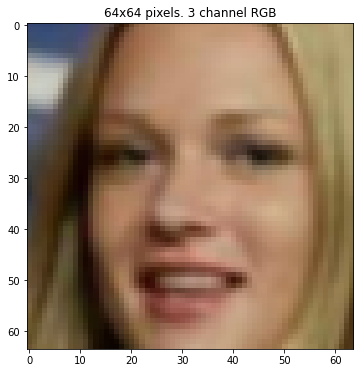

In [154]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(imgs[0])
plt.title("64x64 pixels. 3 channel RGB")
plt.show()

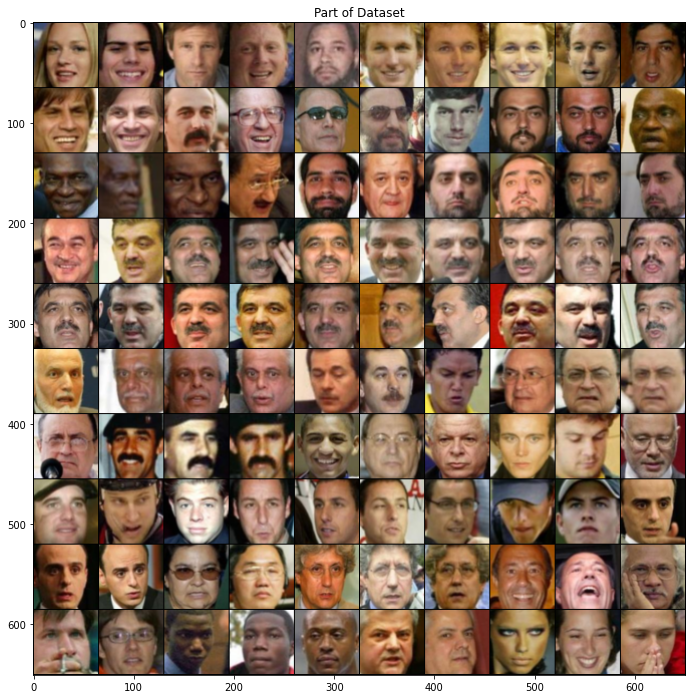

In [173]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img_table(imgs[:100]))
plt.title("Part of Dataset")
plt.show()

In [156]:
IMG_MEAN_PXLS = img_mean_pxls(imgs, 0)
IMG_STD_PXLS = img_std_pxls(imgs, 0)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(IMG_MEAN_PXLS.astype(np.uint8))
plt.title("Average value of each pixel")
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(IMG_STD_PXLS.astype(np.uint8))
axs[0].set_title("Standard deviation of each pixel")

axs[1].imshow(np.mean(img_std_pxls(imgs, 0).astype(np.uint8), axis=2))
axs[1].set_title("A clearer identification")
plt.show()

In [159]:
std_imgs = np.array([
    preprocess(img, IMG_MEAN_PXLS, IMG_STD_PXLS)
    for img in imgs
])

x_train, x_test = train_test_split(std_imgs, test_size=0.1, random_state=42)

len(x_train), len(x_test)

(11909, 1324)

In [160]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size * 2))
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(code_size * 2))
    decoder.add(Dense(np.prod(img_shape)))
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [161]:
IMG_SHAPE = std_imgs.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 256)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 sequential_8 (Sequential)   (None, 256)               6423296   
                                                                 
 sequential_9 (Sequential)   (None, 64, 64, 3)         6435328   
                                                                 
Total params: 12,858,624
Trainable params: 12,858,624
Non-trainable params: 0
_________________________________________________________________
None


In [184]:
history = autoencoder.fit(x=x_train, y=x_train, epochs=30,
                validation_data=[x_test, x_test])

Epoch 1/30
373/373 [==============================] - 54s 146ms/step - loss: 0.0562 - val_loss: 0.0594
Epoch 2/30
373/373 [==============================] - 52s 140ms/step - loss: 0.0552 - val_loss: 0.0586
Epoch 3/30
373/373 [==============================] - 52s 140ms/step - loss: 0.0547 - val_loss: 0.0591
Epoch 4/30
373/373 [==============================] - 52s 140ms/step - loss: 0.0547 - val_loss: 0.0563
Epoch 5/30
373/373 [==============================] - 53s 142ms/step - loss: 0.0544 - val_loss: 0.0572
Epoch 6/30
373/373 [==============================] - 53s 141ms/step - loss: 0.0542 - val_loss: 0.0576
Epoch 7/30
373/373 [==============================] - 53s 141ms/step - loss: 0.0538 - val_loss: 0.0572
Epoch 8/30
373/373 [==============================] - 53s 141ms/step - loss: 0.0537 - val_loss: 0.0576
Epoch 9/30
373/373 [==============================] - 52s 139ms/step - loss: 0.0536 - val_loss: 0.0551
Epoch 10/30
373/373 [==============================] - 52s 140ms/step - l

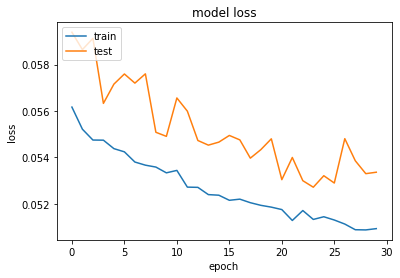

In [185]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [186]:
recs = np.array([
    deprocess(autoencoder.predict(img[None])[0], IMG_MEAN_PXLS, IMG_STD_PXLS)
    for img in x_test
])

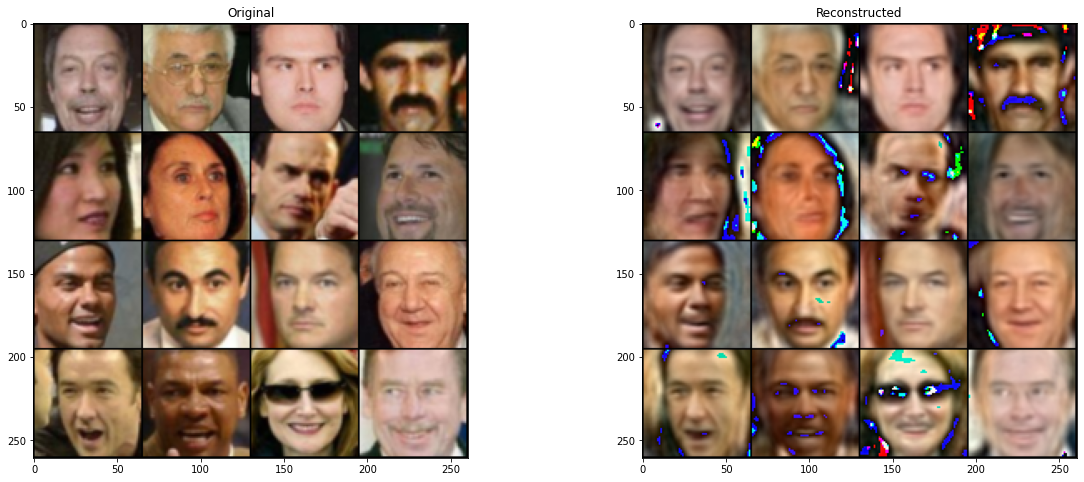

In [187]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].imshow(img_table(
    np.array([
        deprocess(img, IMG_MEAN_PXLS, IMG_STD_PXLS)
        for img in x_test
    ][:16])
))
axs[0].set_title("Original")

axs[1].imshow(img_table(recs[:16]))
axs[1].set_title("Reconstructed")

plt.show()